# Bayesian Regression using Neural nets


In this notebook, we'll cover

* Part 0: Neural nets
* Part 1: Prior over NN weights
* Part 2: NN Regression Model: Prior and Likelihood
* Part 3: Posterior over NN weights
* Part 4: Posterior sampling via Rejection (good for understanding, but not a good choice in practice!)
* Part 5: Posterior predictive for NN prediction

# Prerequisites

We're expecting you've already seen Neural Nets in a previous ML course.

You should have already completed the [day03-C: Neural Nets in JAX](https://github.com/tufts-ml-courses/cs152BDL-22f-assignments/blob/main/day03-B-NeuralNetsJax.ipynb) notebook, where you'd see the neural net coding approach we'll use here.

We'll follow the reading from Neal's PhD Thesis (Sec. 1.1 and 1.2).  In particular, we'll build up to being able to replicate his Figure 1.2, which shows draws from prior and posterior over NN weights on a small example dataset.

# Requirements

There are two ways to run this notebook

<table style="table-medium">
    <tr>
        <td style="align:left; text-align:left;"> <h2> Run in-browser (no install necessary) </h2>
        </td>
        <td style="align:left; text-align:left;"> <h2> Run locally on your computer </h2>
        </td>        
    </tr>
    <tr>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://colab.research.google.com/">Google Colab </a> </p>
             <p>You'll need:</p>
             <ul>
             <li> internet connection </li>
             <li>  Modern browser (Firefox, Chrome, Safari, Edge, etc) </li>
             <li> Google account </li>
             <li> Warning: session will timeout after 12 hours, or sooner if inactive </li>
             <li> Plan to save work if you want it later </li>
         </ul></td>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://jupyter.org/">Jupyter notebook </a> </p>
             <p>You'll need:</p>             <ul>
             <li> Linux, Mac OS or other modern Unix-based OS (sorry, Windows + JAX is difficult) </li>
             <li> Conda package manager </li>
             <li> Python 3.8+ </li>
             <li> All packages from <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/bdl_2022f_env.html">bdl_2022f_env</a> 
                 , see <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/setup_python_env.html">
                 Install Instructions on Course Website </a>
             </li>
         </ul></td>
    </tr>
</table>


In [1]:
# Import numpy and other basic libraries
import numpy as np
import pandas as pd
import time, os, platform

In [2]:
## Import JAX
import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats

In [3]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## Report OS and CPU information

In [4]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: tufts-wifi-10-5-4-240.eecs.tufts.edu
System: Darwin
Version: Darwin Kernel Version 20.6.0: Tue Feb 22 21:10:41 PST 2022; root:xnu-7195.141.26~1/RELEASE_X86_64
Machine: x86_64  Processor: i386
Num cores:  8


## Report exact versions of required packages in local env

In [5]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.22.4
         jax 0.3.17
  matplotlib 3.5.2
     seaborn 0.11.2


# Setup: Neural net code

In [6]:
def make_nn_params_as_list_of_dicts(
        n_dims_input=1,
        n_dims_output=1,
        n_dims_per_hidden_list=[5],
        weight_fill_func=np.zeros,
        bias_fill_func=np.zeros):
    ''' Create a list of dicts structure defining a neural network
    
    Args
    ----
    n_dims_input : int
    n_dims_output : int
    n_hiddens_per_layer_list : list of int
    weight_fill_func : callable, like np.zeros
    bias_fill_func : callable, like np.zeros
    
    Returns
    -------
    nn_params : list of dicts
        Each dict has two keys, 'w' and 'b', for weights and biases
        The values are arrays of the specified shape.
    '''
    nn_param_list = []
    n_per_layer_list = [n_dims_input] + n_dims_per_hidden_list + [n_dims_output]

    # Given full network size list is [a, b, c, d, e]
    # Loop over adjacent pairs: (a,b) , (b,c) , (c,d) , (d,e)
    for n_in, n_out in zip(n_per_layer_list[:-1], n_per_layer_list[1:]):
        nn_param_list.append(
            dict(
                w=weight_fill_func((n_in, n_out)),
                b=bias_fill_func((n_out,)),
            ))
    return nn_param_list

In [7]:
def pretty_print_nn_param_list(nn_param_list_of_dict):
    ''' Create pretty display of the parameters at each layer
    '''
    with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
        for ll, layer_dict in enumerate(nn_param_list_of_dict):
            print("Layer %d" % ll)
            print("  w | shape %9s | %s" % (layer_dict['w'].shape, layer_dict['w'].flatten()))
            print("  b | shape %9s | %s" % (layer_dict['b'].shape, layer_dict['b'].flatten()))

In [8]:
def subtract_pytree_and_scalar(a_pytree, b):
    ''' Add the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b
    '''
    return jax.tree_map(lambda a: a - b, a_pytree)

def subtract_pytrees(a_pytree, b_pytree):
    ''' Subtract one pytree from another
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b_pytree
    '''
    return jax.tree_map(lambda a,b: a - b, a_pytree, b_pytree)

In [9]:
def multiply_pytree_and_scalar(a_pytree, b):
    ''' Multiply the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b
    '''
    return jax.tree_map(lambda a: a * b, a_pytree)

def eltwise_multiply_pytrees(a_pytree, b_pytree):
    ''' Multiply corresponding elts of two pytrees
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b_pytree
    '''
    return jax.tree_map(lambda a,b: a*b,
            a_pytree, b_pytree,
        )

# Part 0: Neural Nets in Math


We want to solve a regression problem, where our observed "inputs" are vectors $x_i$ in $F$-dimensional space, and the observed "outputs" are scalars $y_i \in \mathbb{R}$. We'll have a training set of $N$ observations:
$\{x_n, y_n\}_{n=1}^N$, where each input vector $x_n$ has size $F$ and each output $y_n$ has size 1. 

The neural net is a **deterministic** function that maps each input $x_n$ to an output $y_n$:

$$
    y_n \approx f( x_n; \mathbf{w}, \mathbf{b} )
$$

We consider a general feed-forward neural network (multi-layer perceptron) with $L \geq 1$ total layers (including the output layer and $L-1$ hidden layers). We'll index each layer with integer identifier $\ell \in 1, 2, \ldots \ell, \ldots L$. We'll often use this indicator via a **superscript** to index a specific layer.

To help us keep track of things, we'll define our layers such that each layer $\ell$ produces a vector $h^{\ell}$ with size given by the integer $J^\ell$. Let integer $J^0 = F$ define the input dimension. Then let $J^1, J^2, \ldots J^{L-1}$ define the hidden layer sizes. Finally, $J^L$ defines the output layer size, which we always fix to $J^L = 1$.

**Hidden layer 1:** The 1st layer takes input of size $J^0 = F$ and produces a vector $h^{1}$ of size $J^1$. The parameters of this layer are the weights $w^{1} \in \mathbb{R}^{J^1 \times J^0}$ and the bias $b^{1} \in \mathbb{R}^{ J^1}$. 

\begin{align}
h^{1}(x,w,b) = \left[\begin{array}{c}
    h^1_1(x,w,b) \\
    h^1_2(x,w,b) \\
    \vdots \\
    h^1_{J^1}(x,w,b)
\end{array}\right], \qquad
h^{1}_{j}(x, w, b) = \text{a}\left(
    b^{1}_{j} + \sum_{k=1}^{J^0} w^{1}_{j,k} x_{k}
    \right)
\end{align}

As defined above, each hidden unit in layer one, indexed by $j$, produces a scalar value $h^{1}_{j}$ by multiplying each entry of input vector $x$ by a corresponding weight, adding a scalar bias, and feeding the resulting scalar through an activation function $\text{a}(\cdot)$.

For now, we'll use a $\text{tanh}$ activation function


**Hidden layers 2, 3, ... L-1:**

Each subsequent hidden layer (indexed by $\ell \in 2, 3, \ldots L-1$), takes input of size $J^{\ell-1}$ and produces output of size $J^{\ell}$. The parameters of this layer are the weights $w^{\ell} \in \mathbb{R}^{J^{\ell} \times J^{\ell-1}}$, and the bias vector $b^{\ell} \in \mathbb{R}^{J^\ell}$.

\begin{align}
h^{\ell}(x,w,b) = \left[\begin{array}{c}
    h^\ell_1(x,w,b) \\
    h^\ell_2(x,w,b) \\
    \vdots \\
    h^\ell_{J^\ell}(x,w,b)
\end{array}\right], \qquad
h^{\ell}_{j}(x, w, b) = \text{a}\left(
    b^{\ell}_{j} + \sum_{k=1}^{J^{\ell-1}} w^{\ell}_{j,k} x_{k}
    \right)
\end{align}

As defined above, hidden unit of layer $\ell$, indexed by $j$, is produced by weight multiplication, adding a bias, then feeding through an activation function:


**Final output layer:** At the final layer with index $L$, we take input of size $J^{L-1}$ and produce a scalar predicted output. The parameters are weights $w^{(L)} \in \mathbb{R}^{1 \times J^{L-1}}$ and bias $b^{(L)} \in \mathbb{R}^{1}$. 

The scalar output value $f(x, w, b)$ is given as follows:

$$
f(x, w, b) = b^{(L)}_{1} + \sum_{k=1}^{J^{L-1}} w^{L}_{1, k} h^{L-1}_{k}(x,w,b)
$$

Note: there is NOT any activation function applied to the output layer. We're assuming a regression application where the output could take any real value.

### Worked Example 0A: Implement the prediction function f(...) in Python 

Using our list-of-dict NN representation from day03, let's implement the prediction function f(...) defined above.

To efficiently produce predictions for many inputs at once, we'll write the code in **vectorized** fashion

* input is (n_examples, F)
* output is (n_examples, 1)

In [10]:
def predict_f_given_x_via_NN(x_NF=None, nn_param_list=None, activation_func=jnp.tanh):
    """ Compute scalar output of a feed-forward neural net
    
    Args
    ----
    x_NF : 2D array, shape (N,F) = (n_examples, n_input_dims)
        F-dim feature vector for each example
    nn_param_list : list of dict
        Parameters of neural network
    activation_func : callable
        Activation function of the neural net
        Must be differentiable using jax.grad

    Returns
    -------
    f_N : 1D array, shape (N,) = (n_examples,)
        Predicted function value for each feature vector
    """
    assert x_NF.ndim == 2 # verify input features have shape (N,F)
    n_layers = len(nn_param_list)
    h_arr = x_NF
    i = 0
    for layer_dict in nn_param_list:
        # let i denote the current layer id
        i += 1
        # h_arr is the "input" to current layer, shape (N,J^i-1)
        # out_arr is "output" of the current layer, shape (N,J^i)
        # w is 2D array with shape (J^i, J^i-1)
        # b is 1D array with shape (J^i)
        out_arr = jnp.dot(h_arr, layer_dict['w']) + layer_dict['b']
        if i < n_layers:
            # If NOT the last layer, we apply activation func to each entry of out_arr
            h_arr = activation_func(out_arr)
    # Squeeze so returned shape becomes (N,) not (N,1)
    return jnp.squeeze(out_arr)

In [11]:
nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1,
    n_dims_output=1,
    n_dims_per_hidden_list=[5])

In [12]:
pretty_print_nn_param_list(nn_params)

Layer 0
  w | shape    (1, 5) | [ 0.000  0.000  0.000  0.000  0.000]
  b | shape      (5,) | [ 0.000  0.000  0.000  0.000  0.000]
Layer 1
  w | shape    (5, 1) | [ 0.000  0.000  0.000  0.000  0.000]
  b | shape      (1,) | [ 0.000]


In [13]:
predict_f_given_x_via_NN(np.asarray([[0.5]]), nn_params)

DeviceArray(0., dtype=float32)

In [14]:
predict_f_given_x_via_NN(np.asarray([[0.5], [-0.5]]), nn_params)

DeviceArray([0., 0.], dtype=float32)

# Part 1: Prior over NN weights/biases

We'll assume that for all layers, the weights and biases have a Gaussian prior with mean zero and variance $\sigma^2$.

\begin{align}
p(w, b) = \prod_{\ell=1}^L
          \prod_{j=1}^{J^{\ell}} 
          \prod_{k=1}^{J^{\ell-1}} \mathcal{N}( w^{\ell}_{j,k} | 0, \sigma^2)
          \cdot
          \prod_{\ell=1}^L
          \prod_{j=1}^{J^\ell}
            \mathcal{N}( b^{\ell}_j | 0, \sigma^2)
\end{align}

## Worked example 1A: Drawing samples of neural net weights from this prior

In [15]:
def fill_with_draws_from_Normal_prior(shape, mean=0.0, stddev=1.0, persistent_state={'seed':0}):
    # increment the seed
    persistent_state['seed'] += 1
    prng = np.random.RandomState(persistent_state['seed'])
    return prng.normal(mean, stddev, size=shape)

In [17]:
sampleA_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1,
    n_dims_output=1,
    n_dims_per_hidden_list=[5],
    weight_fill_func=fill_with_draws_from_Normal_prior,
    bias_fill_func=fill_with_draws_from_Normal_prior)
pretty_print_nn_param_list(sampleA_nn_params)

Layer 0
  w | shape    (1, 5) | [ 0.441 -0.331  2.431 -0.252  0.110]
  b | shape      (5,) | [-0.312  0.729  0.218 -0.899 -2.487]
Layer 1
  w | shape    (5, 1) | [ 1.691 -0.466  0.033  0.408 -0.789]
  b | shape      (1,) | [ 0.091]


In [18]:
sampleB_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1,
    n_dims_output=1,
    n_dims_per_hidden_list=[5],
    weight_fill_func=fill_with_draws_from_Normal_prior,
    bias_fill_func=fill_with_draws_from_Normal_prior)
pretty_print_nn_param_list(sampleB_nn_params)

Layer 0
  w | shape    (1, 5) | [ 0.001 -0.290 -1.116 -0.013 -0.378]
  b | shape      (5,) | [ 1.332  0.715 -1.545 -0.008  0.621]
Layer 1
  w | shape    (5, 1) | [ 1.749 -0.286 -0.485 -2.653 -0.008]
  b | shape      (1,) | [ 0.473]


## Util func to plot sampled functions

In [19]:
def draw_sample_of_f_from_BNN_prior_at_x_grid(
        x_grid_G, n_dims_per_hidden_list,
        weight_mean=0.0, weight_stddev=1.0,
        bias_mean=0.0, bias_stddev=1.0,
        random_state=42,
        n_samples=1):
    """ Draw sample from GP prior given mean/cov functions

    Args
    ----
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    random_state : int
        Seed for the random number generator
    n_samples : int
        Number of samples to draw from the prior    

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    S = int(n_samples)
    G = x_grid_G.size
    x_grid_G1 = np.reshape(x_grid_G, (G,1))
    

    def draw_weights_from_Normal_prior(shape, persistent_state={'seed':int(random_state)}):
        # increment the seed
        persistent_state['seed'] += 1
        prng = np.random.RandomState(persistent_state['seed'])
        return prng.normal(weight_mean, weight_stddev, size=shape)
    def draw_biases_from_Normal_prior(shape, persistent_state={'seed':int(random_state)+1001}):
        # increment the seed
        persistent_state['seed'] += 1
        prng = np.random.RandomState(persistent_state['seed'])
        return prng.normal(bias_mean, bias_stddev, size=shape)
    
    f_SG = np.zeros((S, G))
    for ss in range(S):
        sample_nn_params = make_nn_params_as_list_of_dicts(
            n_dims_input=1,
            n_dims_output=1,
            n_dims_per_hidden_list=n_dims_per_hidden_list,
            weight_fill_func=draw_weights_from_Normal_prior,
            bias_fill_func=draw_biases_from_Normal_prior)
        f_SG[ss] = predict_f_given_x_via_NN(x_grid_G1, sample_nn_params)
        
    return f_SG

## Util functions to make pretty plots

In [20]:
def plot_f_samples_at_x_grid(x_grid_G, f_grid_SG,
                             color=None, axis_handle=None):
    if axis_handle is None:
        axis_handle = pylab.gca() # get current axis handle if not provided
    S, G = f_grid_SG.shape
    for s in range(S):
        axis_handle.plot(x_grid_G, f_grid_SG[s], '-', color=color)

In [21]:
H = 4 # Panel height
W = 6 # Panel width

S = 5 # num samples to draw from posterior

G = 501  # num grid points to use
x_grid_G = np.linspace(-6, 6, G)

In [22]:
def make_prior_sample_viz_for_arch(n_dims_per_hidden_list):
    if len(n_dims_per_hidden_list) == 0:
        first_layer_size = 0
    else:
        first_layer_size = n_dims_per_hidden_list[0]
    stddev_list = [0.333, 1.0, 3.0]
    ncols = len(stddev_list)
    nrows = 1

    fig_h, axes_list = plt.subplots(
        nrows=nrows, ncols=ncols,
        sharex=True, sharey=True,
        figsize=(W*ncols, H*nrows))
    for ii, stddev in enumerate(stddev_list):
        cur_ax_h = axes_list[ii]

        f_grid_SG = draw_sample_of_f_from_BNN_prior_at_x_grid(
            x_grid_G, n_dims_per_hidden_list,
            weight_stddev = stddev,
            bias_stddev = stddev,
            n_samples=S,
            random_state=ii * len(n_dims_per_hidden_list) + first_layer_size)
        assert f_grid_SG.shape == (S, G)

        plot_f_samples_at_x_grid(
            x_grid_G,
            f_grid_SG,
            axis_handle=cur_ax_h,
            )
        cur_ax_h.set_title('stddev\n' + r'$\sigma$ = %.2f' % stddev)
        cur_ax_h.set_xlabel('x');
        cur_ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
        if ii == 0: cur_ax_h.set_ylabel('f(x)');
        cur_ax_h.set_yticks([-4, -2, 0, 2, 4]);
        cur_ax_h.set_ylim([-6, 6])
    plt.subplots_adjust(hspace=0, wspace=0.1)

## Fig 1(a) : Draws from the prior with arch [ ]

Here, we're looking at a NN with

* 1 input feature
* zero hidden layers
* 1 output

This is equivalent to linear regression!

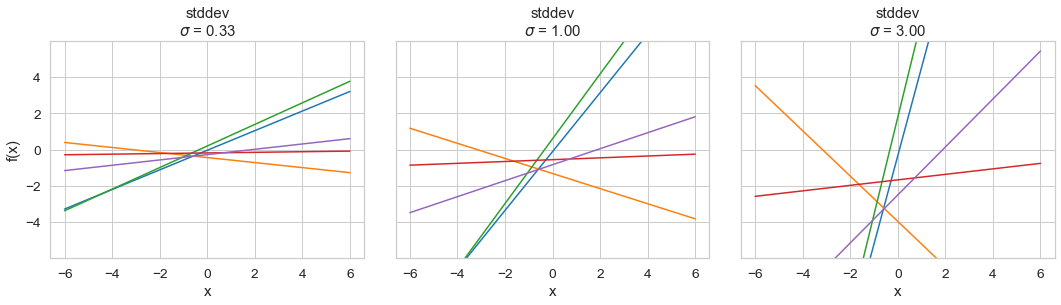

In [23]:
make_prior_sample_viz_for_arch([])

## Fig 1(b) : Draws from the prior with arch [4]

With four hidden units, the functions can show some non-linearity

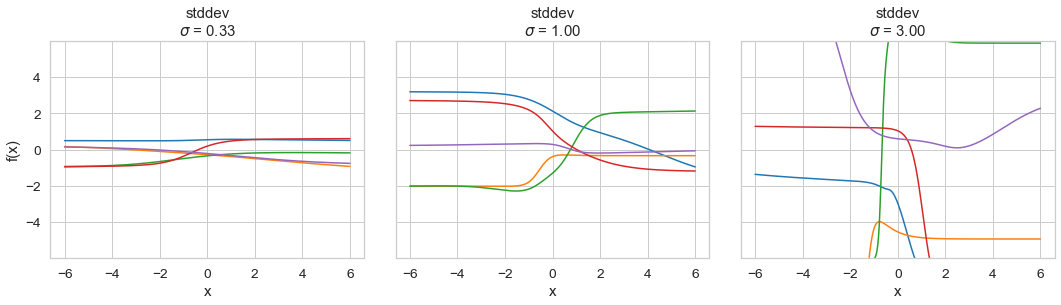

In [24]:
make_prior_sample_viz_for_arch([4])

## Fig 1(c) : Draws from the prior with arch [16]

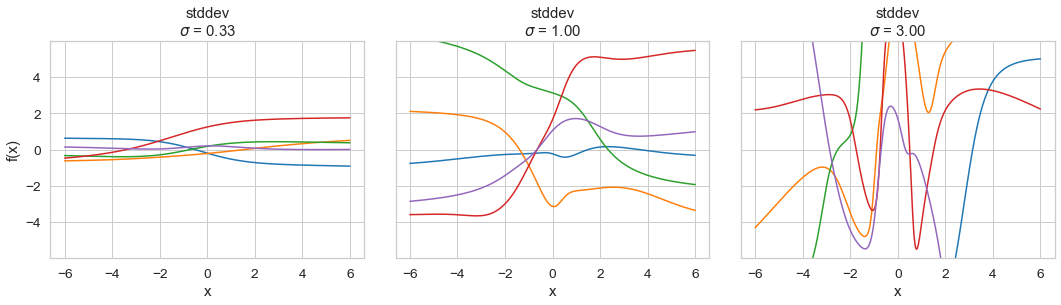

In [25]:
make_prior_sample_viz_for_arch([16])

## Fig 1(d) : Draws from the prior with arch [64]

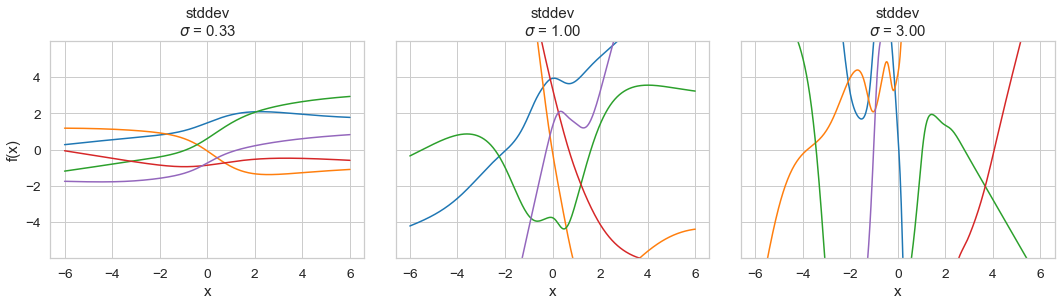

In [26]:
make_prior_sample_viz_for_arch([64])

## Fig 1(d): Draws from the prior with arch [1024]

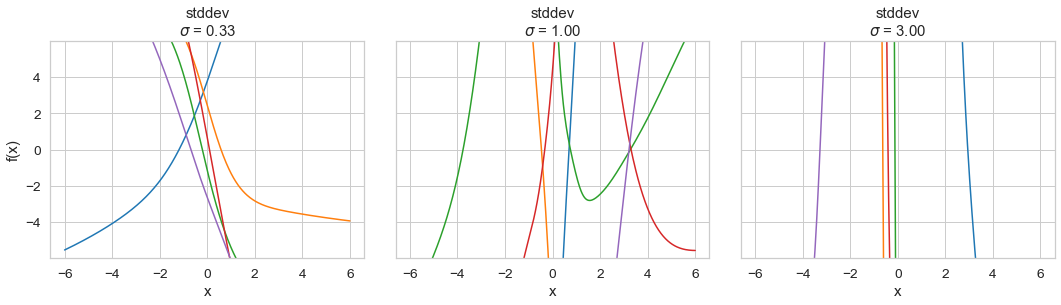

In [27]:
make_prior_sample_viz_for_arch([1024])

## Fig 1(e) : Draws from the prior with arch [64,64]

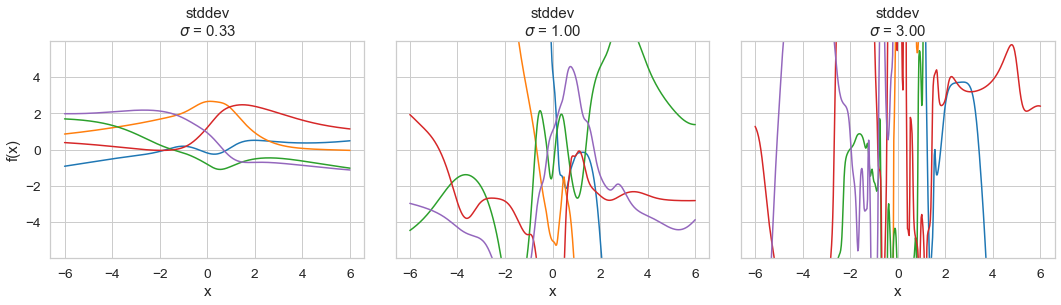

In [28]:
make_prior_sample_viz_for_arch([64, 64])

## Fig 1(f) : Draws from the prior with arch [64,64,64,64,64]

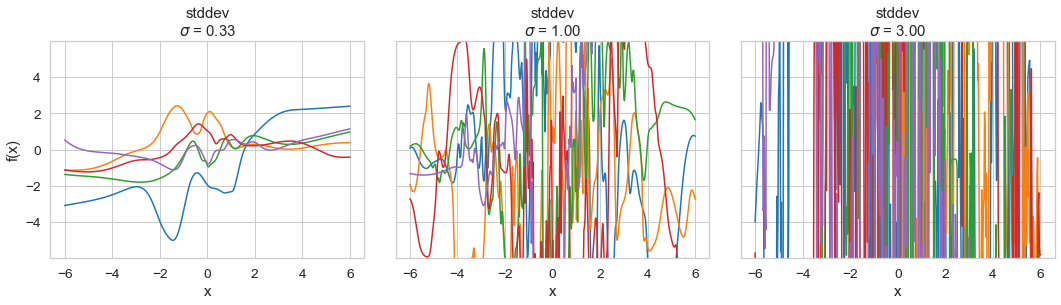

In [29]:
make_prior_sample_viz_for_arch([64,64,64,64,64])

# Part 2: Probabilistic model for Regression with Neural Nets

Random variables:

* $\mathbf{y}$ : output values of the regression (observed for the $N$ training examples)
* $\mathbf{w}$ : weight parameters of the neural net
* $\mathbf{b}$ : bias parameters of the neural net

We'll define a prior and likelihood that together form the **joint** over all random variables of interest.

**Prior**: 

\begin{align}
p( \mathbf{w}, \mathbf{b} ) = 
    \prod_{\ell=1}^L \prod_{j=1}^{J^{\ell-1}} \prod_{k=1}^{J^{\ell}} \mathcal{N}(w_{jk}^{\ell} | \mu_W, \sigma_W^2)
    \cdot
    \prod_{\ell=1}^L \prod_{k=1}^{J^{\ell}} \mathcal{N}( b_k^{\ell} | \mu_B, (\sigma_B)^2)
\end{align}

where the parameters are:

* $\mu_W \in \mathbb{R}$ : scalar mean of weights
* $\sigma_W > 0$ : scalar std. dev. of weights
* $\mu_B \in \mathbb{R}$ : scalar mean of bias
* $\sigma_B > 0$ : scalar std. dev. of bias


**Likelihood**:

\begin{align}
p( \mathbf{y} | \mathbf{w}, \mathbf{b} ) 
&= \prod_i p( y_i | \mathbf{w}, \mathbf{b} ) 
\\
&= \prod_i \mathcal{N}( y_i | f(x_i ; \mathbf{w}, \mathbf{b}), \tau^2 )
\end{align}

where the parameters are:

* $\tau > 0$ : scalar std. deviation for the outputs $y$

We can implement these **probability density** functions in log-space for numerical stability

In [30]:
def calc_logpdf_prior(nn_params, prior_params={
        'w_mean':0.0, 'w_stddev':1.0,
        'b_mean':0.0, 'b_stddev':1.0}):
    L = len(nn_params)
    total_logpdf = 0.0
    for ll in range(L):
        w_arr = nn_params[ll]['w']
        b_arr = nn_params[ll]['b']
        total_logpdf += jstats.norm.logpdf(
            w_arr, prior_params['w_mean'], prior_params['w_stddev'])
        total_logpdf += jstats.norm.logpdf(
            b_arr, prior_params['b_mean'], prior_params['b_stddev'])
    return total_logpdf

In [31]:
def calc_logpdf_likelihood(nn_params, x_NF, y_N,
                           lik_params={'tau':.1}):
    f_N = predict_f_given_x_via_NN(x_NF, nn_params)
    logpdf_N = jstats.norm.logpdf(y_N, f_N, lik_params['tau'])
    return jnp.sum(logpdf_N)

In [32]:
nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1, n_dims_output=1, n_dims_per_hidden_list=[])

In [33]:
nn_params

[{'w': array([[0.]]), 'b': array([0.])}]

In [34]:
calc_logpdf_prior(nn_params)

DeviceArray([[-1.837877]], dtype=float32)

## Setup: Toy dataset with true LINEAR relationship

In [36]:
N = 300
F = 1
true_tau = 0.09

true_w_F = np.asarray([.42])

train_prng = np.random.RandomState(101)
x_NF = train_prng.uniform(low=-3, high=3, size=(N,F))
y_N = np.dot(x_NF, true_w_F) + true_tau * train_prng.randn(N)

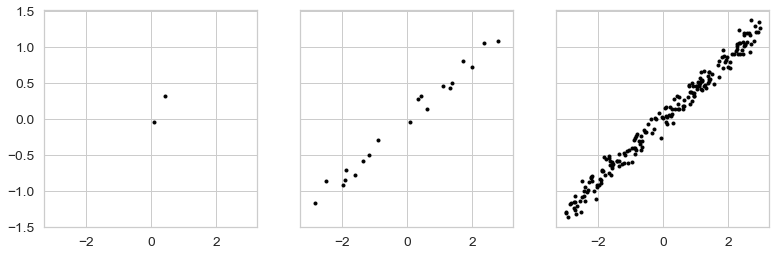

In [37]:
_, axgrid = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharey=True, sharex=True)

for (panel_id, N) in [(0, 2), (1, 20), (2, 200)]:
    axgrid[panel_id].plot(
        x_NF[:N,0], y_N[:N], 'k.')

## Setup: Gradient Descent 

Same procedure we encountered in day03-C notebook

In [38]:
def run_many_iters_of_grad_descent(
        calc_loss_and_grad,
        init_nn_param_pytree,
        n_iters=100, step_size=0.001,
        print_every=None):
    ''' Run many iterations of gradient descent
    
    Args
    ----
    calc_loss_and_grad : function
        Computes the loss and gradient that we want to minimize
        By using ONE function, we can avoid duplicating passes thru our neural net (saving time)
        
    init_nn_param_pytree : PyTree list of dicts
        Initial value of neural net parameters
    
    Returns
    -------
    opt_nn_param_pytree : PyTree list of dicts
        Final value of neural net parameters
        If converged, should be local optima of loss function
    history : dict of lists
        Provides history of the function value and other useful summaries
    '''
    # Copy the initial parameters
    nn_param_pytree = multiply_pytree_and_scalar(init_nn_param_pytree, 1.0)
    
    # Create data structs to track per-iteration history
    # of different quantities
    history = dict(
        iter=[],
        loss=[],
        param_values=[],
        gradient_values=[])

    start_time = time.time()
    grad_pytree = None # Will be overwritten later
    for iter_id in range(n_iters+1):
        if iter_id > 0:                
            # x <- x - step_size * g
            nn_param_pytree = subtract_pytrees(nn_param_pytree,
                multiply_pytree_and_scalar(grad_pytree, step_size))

        loss, grad_pytree = calc_loss_and_grad(nn_param_pytree)
        history['iter'].append(iter_id)
        history['loss'].append(loss)
        history['param_values'].append(nn_param_pytree)
        history['gradient_values'].append(grad_pytree)
        
        if isinstance(print_every, int) and iter_id % print_every == 0:
            print("iter %4d/%d after %5.1f sec : loss %11.6f" % (
                iter_id, n_iters, time.time() - start_time, history['loss'][-1]))
    return nn_param_pytree, history

## Worked example 3A: Fit ML estimated weights at N = 2, 20, and 200

In [39]:
zero_nn_params = make_nn_params_as_list_of_dicts(
    n_dims_input=1,
    n_dims_output=1,
    n_dims_per_hidden_list=[],
    weight_fill_func=np.zeros,
    bias_fill_func=np.zeros)

print("INITIAL PARAMETERS (all zero)")
pretty_print_nn_param_list(zero_nn_params)

INITIAL PARAMETERS (all zero)
Layer 0
  w | shape    (1, 1) | [ 0.000]
  b | shape      (1,) | [ 0.000]


In [52]:
nn_params_per_N = {}
for N, step_size in [(2, 0.0003), (20, 0.00001), (200, 0.000001)]:
    def calc_loss_at_N(nn_params):
        return -1.0 * calc_logpdf_likelihood(
            nn_params, x_NF[:N], y_N[:N], lik_params={'tau':.1})
    calc_loss_and_grad_at_N = jax.value_and_grad(calc_loss_at_N)
    fast_loss_and_grad_at_N = jax.jit(calc_loss_and_grad_at_N)
    print("FITTING model to N=%d train data" % N)
    fromzero_nn_params, fromzero_history = run_many_iters_of_grad_descent(
        fast_loss_and_grad_at_N,
        zero_nn_params,
        n_iters=800,
        step_size=step_size,
        print_every=100)
    nn_params_per_N[N] = fromzero_nn_params

FITTING model to N=2 train data
iter    0/800 after   0.1 sec : loss    2.491136
iter  100/800 after   0.1 sec : loss   -0.544844
iter  200/800 after   0.1 sec : loss   -1.116740
iter  300/800 after   0.1 sec : loss   -1.541469
iter  400/800 after   0.1 sec : loss   -1.856905
iter  500/800 after   0.1 sec : loss   -2.091171
iter  600/800 after   0.1 sec : loss   -2.265155
iter  700/800 after   0.1 sec : loss   -2.394369
iter  800/800 after   0.1 sec : loss   -2.490331
FITTING model to N=20 train data
iter    0/800 after   0.1 sec : loss  459.205658
iter  100/800 after   0.1 sec : loss  -18.839205
iter  200/800 after   0.1 sec : loss  -18.846949
iter  300/800 after   0.1 sec : loss  -18.847031
iter  400/800 after   0.1 sec : loss  -18.847029
iter  500/800 after   0.1 sec : loss  -18.847031
iter  600/800 after   0.1 sec : loss  -18.847029
iter  700/800 after   0.1 sec : loss  -18.847031
iter  800/800 after   0.1 sec : loss  -18.847031
FITTING model to N=200 train data
iter    0/800 after

In [53]:
G = 501
x_grid_G1 = np.linspace(-5, 5, G).reshape((G,1))

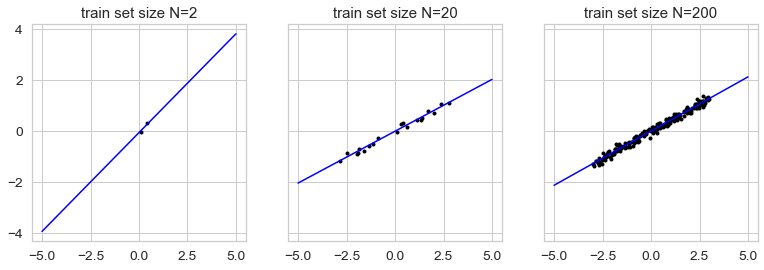

In [54]:
_, axgrid = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharey=True, sharex=True)

for (panel_id, N) in [(0, 2), (1, 20), (2, 200)]:
    axgrid[panel_id].plot(
        x_NF[:N,0], y_N[:N], 'k.')
    axgrid[panel_id].plot(
        x_grid_G1[:,0], predict_f_given_x_via_NN(x_grid_G1, nn_params_per_N[N]), 'b-')
    axgrid[panel_id].set_title('train set size N=%d' % N)

# Part 3: Posterior of the NN Regression model

Applying Bayes rule to the model defined above, we have

\begin{align}
p( \mathbf{w}, \mathbf{b} | \mathbf{y}_{1:N} ) &= \frac{ 
    p(\mathbf{w}, \mathbf{b}) p( \mathbf{y}_{1:N} | \mathbf{w}, \mathbf{b} )
    }
    { p(\mathbf{y}_{1:N}) }
\end{align}

This is the PDF of the **posterior distribution** over weights and biases.

There are two things we'd like to do with this posterior, ideally:

* SAMPLE FROM THE DISTRIBUTION : drawing weights/biases from the posterior
* EVALUATE THE PROBABILITY DENSITY FUNCTION: given a weight/bias value of interest, we could ask about the probability density assigned under the posterior

We'll find out that the first goal (sampling) is perhaps easier than the second goal (evaluating the PDF).

## The problem with evaluating the PDF

We know how to compute each term in the numerator. However, the denominator is challenging. Why?
 
By the sum rule, we can rewrite the denominator term as the integral over our model's full joint distribution, integrating away all weights and biases

\begin{align}
p( \mathbf{y}_{1:N} ) = \int p( \mathbf{y}_{1:N}, \mathbf{w}, \mathbf{b} ) d\mathbf{w} d\mathbf{b} 
\end{align}

The resulting distribution is also called the "marginal likelihood"

Even for small neural net architectures, this integral is tough to compute. There's no closed form except if there are *no hidden layers at all* (in which case, we recover the linear-Gaussian model from day01).



## Viewing the posterior pdf as a function of weights

How to proceed? Well, even though we can't compute the marginal likelihood $p(y_{1:N})$, let's remember that this term does not depend on a particular value of weights/biases. It is constant wrt $\mathbf{w}, \mathbf{b}$.

Viewing the posterior PDF as a *function* of particular weights/biases, we can write the posterior PDF as

\begin{align}
p( \mathbf{w}, \mathbf{b} | \mathbf{y}_{1:N} ) = c \cdot
    p(\mathbf{w}, \mathbf{b}) p( \mathbf{y}_{1:N} | \mathbf{w}, \mathbf{b} )
\end{align}

where $c > 0$ is some unknown but fixed constant no matter what $\mathbf{w}, \mathbf{b}$ we ask about.

Now, suppose we've found an ML estimate of weights and biases for the given dataset $\mathbf{y}_{1:N}$, by solving the problem:

\begin{align}
\mathbf{w}^{ML}, \mathbf{b}^{ML} \gets \arg\,\max_{\mathbf{w}, \mathbf{b}} ~~ \log p( \mathbf{y}_{1:N} | \mathbf{w}, \mathbf{b} )
\end{align}

We can then establish an inequality relationship between the posterior PDF and the prior PDF, that is true for all possible values of $\mathbf{w},\mathbf{b}$:

\begin{align}
p( \mathbf{w}, \mathbf{b} | \mathbf{y}_{1:N} ) 
    &= c \cdot
    p( \mathbf{y}_{1:N} | \mathbf{w}, \mathbf{b} ) p(\mathbf{w}, \mathbf{b})
    \\
    &\leq c \cdot \underbrace{p( \mathbf{y}_{1:N} | \mathbf{w}^{ML}, \mathbf{b}^{ML} )}_{M} p(\mathbf{w}, \mathbf{b}) 
\end{align}

Below, we'll see how this bounding relationship gives us a way to draw **samples** from the posterior.

# Part 4: Rejection sampling from the posterior

## Rejection sampling, in general

Suppose we have two distributions $p(u)$ and $q(u)$ that each provide positive density to all values of a random variable $u \in \Omega$

Further assume that:

* It is "easy" to sample from $q$
* It is "easy" to evaluate both PDFs $q(u)$ and $p(u)$, or at least evaluate the ratio $p(u) / q(u)$
* For all values $u \in \Omega$, we know that $p(u) \leq k q(u)$, for some constant $k>0$

Then the following algorithm can be used to sample from $p$

<div class="alert alert-info">
<h3> Algorithm: REJECTION SAMPLING </h3>

Repeat until a sample is accepted:
    
  1. Draw $u \sim q$
  2. Compute acceptance probability $a \gets \frac{ p(u) }{ k q(u) }$
  3. Draw acceptance value $\rho \in (0,1)$ from a Uniform over the 0-1 interval
  4. Decide whether to accept or reject the sample

\begin{align}
    \begin{array}{l l}
    \text{accept $u$ as sample from $p$} & ~\text{if}~ \rho < a
    \\
    \text{reject} & ~\text{otherwise}
    \end{array}
\end{align}
    
</div>

## Rejection sampling from the posterior

We can use the generic rejection sampling idea to sample from the posterior!

Let the proposal distribution be the prior over weights, since we can evaluate its PDF and sample from it.

Let the target distribution be the posterior over weights, because (as we'll see below) the ratio of PDFs is evaluatable.

This is the approach that today's reading (Neal's thesis, Sec. 1.2.4) refers to.




<div class="alert alert-info">
<h3> Algorithm: REJECTION SAMPLING FROM POSTERIOR OVER NN WEIGHTS </h3>

    
Repeat until a sample is accepted:

  1. Draw weights $w^s, b^s$ from the prior $p( \mathbf{w}, \mathbf{b} )$
  2. Compute the acceptance probability

\begin{align}
a \gets \frac{ c \cdot p( y_{1:N} | \mathbf{w}^s, \mathbf{b}^s ) p(\mathbf{w}^s, \mathbf{b}^s ) }
             { c \cdot M \cdot p(\mathbf{w}^s, \mathbf{b}^s ) } 
      = \frac{ p( y_{1:N} | \mathbf{w}^s, \mathbf{b}^s ) }
             { M }, 
    \qquad
    M \triangleq p( \mathbf{y}_{1:N} | \mathbf{w}^{ML}, \mathbf{b}^{ML} )
\end{align}

  3. Draw acceptance value $\rho \sim \text{Unif}(0,1)$
  4. Decide whether to accept or reject the sample
    
\begin{align}
    \begin{array}{l l}
    \text{accept $w^s,b^s$ as sample from posterior} & ~\text{if}~ \rho < a
    \\
    \text{reject} & ~\text{otherwise}
    \end{array}
\end{align}
                                        
</div>                               

## Implementation of Rejection sampling

Now let's implement this in Python!

In [55]:
def draw_posterior_samples_via_rejection(
        n_dims_per_hidden_list,
        N=3, x_NF=x_NF, y_N=y_N,
        n_samples=5, n_attempts_max=100000, 
        prior_params={'w_mean':0.0, 'w_stddev':1.0, 'b_mean':0.0, 'b_stddev':1.0},
        lik_params={'tau':0.01},
        random_state=101,
        maxlik_n_iters=1000,
        maxlik_step_size=0.0001):
    '''
    '''
    zero_nn_params = make_nn_params_as_list_of_dicts(
        n_dims_input=1,
        n_dims_output=1,
        n_dims_per_hidden_list=n_dims_per_hidden_list,
        weight_fill_func=np.zeros,
        bias_fill_func=np.zeros)
    
    print("Starting phase 1: Grad ascent to find a max-lik estimate of weights.")
    # Descent to minimize negative likelihood is what we'll do
    # dividing by N helps keep optima's loss value at same scale regardless of dataset size
    def calc_loss_at_N(nn_params):
        return -1.0 / N * calc_logpdf_likelihood(nn_params, x_NF[:N], y_N[:N], lik_params)
    fast_loss_and_grad_at_N = jax.jit(jax.value_and_grad(calc_loss_at_N))
    maxlik_nn_params, _ = run_many_iters_of_grad_descent(
        fast_loss_and_grad_at_N,
        zero_nn_params,
        n_iters=maxlik_n_iters,
        step_size=maxlik_step_size,
        print_every=maxlik_n_iters//5)
    print("DONE with phase 1. Maximum-likelihood estimate of weights found.")
    maxlik_logpdf = calc_logpdf_likelihood(maxlik_nn_params, x_NF[:N], y_N[:N], lik_params)

    print("Starting phase 2: rejection sampling, seeking %d samples from posterior" % n_samples)
    weight_mean, weight_stddev = prior_params['w_mean'], prior_params['w_stddev']
    bias_mean, bias_stddev = prior_params['b_mean'], prior_params['b_stddev']
    def draw_weights_from_Normal_prior(shape, persistent_state={'seed':int(random_state)}):
        # increment the seed
        persistent_state['seed'] += 1
        prng = np.random.RandomState(persistent_state['seed'])
        return prng.normal(weight_mean, weight_stddev, size=shape)
    def draw_biases_from_Normal_prior(shape, persistent_state={'seed':int(random_state)+1001}):
        # increment the seed
        persistent_state['seed'] += 1
        prng = np.random.RandomState(persistent_state['seed'])
        return prng.normal(bias_mean, bias_stddev, size=shape)
    
    prng = np.random.RandomState(N * 1000 + n_samples)
    accepted_samples_of_nn_params = []

    for trial_id in range(n_attempts_max):
        if len(accepted_samples_of_nn_params) >= n_samples:
            break
        # STEP 1: Draw sample from prior
        nn_params = make_nn_params_as_list_of_dicts(
            n_dims_input=1, n_dims_output=1,
            n_dims_per_hidden_list=n_dims_per_hidden_list,
            weight_fill_func=draw_weights_from_Normal_prior,
            bias_fill_func=draw_biases_from_Normal_prior)
        
        # STEP 2: Determine accept probability
        accept_proba = np.exp(
            calc_logpdf_likelihood(nn_params, x_NF[:N], y_N[:N], lik_params)
            - maxlik_logpdf)
        assert accept_proba >= 0

        # STEP 3-4: Decide whether to accept/reject using a random draw from Uniform over (0,1) interval
        rho = prng.rand()
        if rho < accept_proba:
            accepted_samples_of_nn_params.append(nn_params)

        if (trial_id+1) % 10000 == 0 and trial_id > 10:
            print("..... accepted %d/%6d samples so far, will try %d total" % (
                len(accepted_samples_of_nn_params), trial_id+1, n_attempts_max))
    print("DONE. Accepted %d/%d samples from the prior" % (
        len(accepted_samples_of_nn_params), trial_id+1))        
    return accepted_samples_of_nn_params

In [57]:
arch = []
prior_params = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0}
lik_params = {'tau':0.3}

In [58]:
nn_samples_at_N = {}
S = 5

In [60]:
nn_samples_at_N[2] = draw_posterior_samples_via_rejection(
    arch, N=2, n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.0009)

Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss    0.007101
iter  200/1000 after   0.1 sec : loss   -0.132768
iter  400/1000 after   0.1 sec : loss   -0.148654
iter  600/1000 after   0.1 sec : loss   -0.161542
iter  800/1000 after   0.1 sec : loss   -0.173194
iter 1000/1000 after   0.1 sec : loss   -0.183746
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
DONE. Accepted 5/408 samples from the prior


In [62]:
nn_samples_at_N[4] = draw_posterior_samples_via_rejection(
    arch, N=4,  n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.00003)

Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss    2.935810
iter  200/1000 after   0.1 sec : loss    1.790621
iter  400/1000 after   0.1 sec : loss    1.068365
iter  600/1000 after   0.1 sec : loss    0.612113
iter  800/1000 after   0.1 sec : loss    0.323216
iter 1000/1000 after   0.1 sec : loss    0.139659
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
DONE. Accepted 5/1218 samples from the prior


In [63]:
nn_samples_at_N[8] = draw_posterior_samples_via_rejection(
    arch, N=8,  n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.0001)

Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss    2.772841
iter  200/1000 after   0.1 sec : loss    0.535499
iter  400/1000 after   0.1 sec : loss   -0.045021
iter  600/1000 after   0.1 sec : loss   -0.195686
iter  800/1000 after   0.1 sec : loss   -0.234812
iter 1000/1000 after   0.1 sec : loss   -0.244989
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
DONE. Accepted 5/5360 samples from the prior


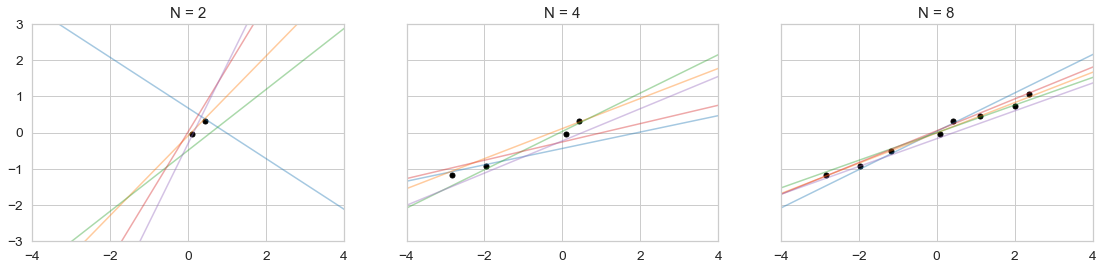

In [66]:
ncols = 3
_, axgrid = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*W+1, H), sharey=True, sharex=True)

for (panel_id, N) in [(0, 2), (1, 4), (2, 8)]:
    axgrid[panel_id].plot(
        x_NF[:N,0], y_N[:N], 'k.', markersize=10)
    S_N = len(nn_samples_at_N[N])
    for ss in range(S_N):
        nn_params = nn_samples_at_N[N][ss]
        axgrid[panel_id].plot(
            x_grid_G1[:,0],
            predict_f_given_x_via_NN(x_grid_G1, nn_params), '-', alpha=0.4)
    axgrid[panel_id].set_title("N = %d" % N)
plt.xlim([-4, 4]);
plt.ylim([-3, 3]);

## Toy dataset with true NON-linear relationship

In [67]:
N = 300
F = 1
true_tau = 0.15

def f_true(x):
    return np.exp(-x/10) * np.cos(x)

train_prng = np.random.RandomState(101)
x_NF = train_prng.uniform(low=-10, high=10, size=(N,F))
y_N = np.squeeze(f_true(x_NF)) + true_tau * train_prng.randn(N,)

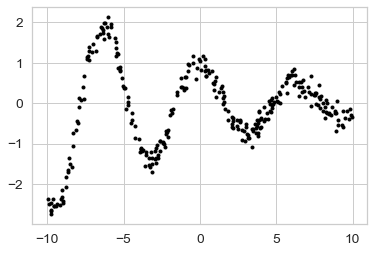

In [68]:
plt.plot(x_NF[:,0], y_N, 'k.');

In [69]:
G = 501
x_grid_G1 = np.linspace(-10, 10, G).reshape((G,1))

In [70]:
arch = []
prior_params = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0}
lik_params = {'tau':0.3}

nn_samples_at_N = {}
S = 5

In [73]:
nn_samples_at_N[4] = draw_posterior_samples_via_rejection(
    arch, N=4, x_NF=x_NF, y_N=y_N, n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.0009)

Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss   13.754086
iter  200/1000 after   0.1 sec : loss   10.256447
iter  400/1000 after   0.1 sec : loss   10.116446
iter  600/1000 after   0.1 sec : loss   10.104536
iter  800/1000 after   0.1 sec : loss   10.103523
iter 1000/1000 after   0.1 sec : loss   10.103437
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
DONE. Accepted 5/6407 samples from the prior


In [74]:
nn_samples_at_N[20] = draw_posterior_samples_via_rejection(
    arch, N=20, x_NF=x_NF, y_N=y_N, n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.0009)

Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss    6.229631
iter  200/1000 after   0.1 sec : loss    6.215109
iter  400/1000 after   0.1 sec : loss    6.214937
iter  600/1000 after   0.1 sec : loss    6.214933
iter  800/1000 after   0.1 sec : loss    6.214933
iter 1000/1000 after   0.1 sec : loss    6.214933
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
..... accepted 0/ 10000 samples so far, will try 100000 total
..... accepted 0/ 20000 samples so far, will try 100000 total
..... accepted 1/ 30000 samples so far, will try 100000 total
..... accepted 1/ 40000 samples so far, will try 100000 total
..... accepted 3/ 50000 samples so far, will try 100000 total
..... accepted 3/ 60000 samples so far, will try 100000 total
..... accepted 4/ 70000 samples so far, will try 100000 total
..... accepted 4/ 80000 samples so far, will try 100000 total

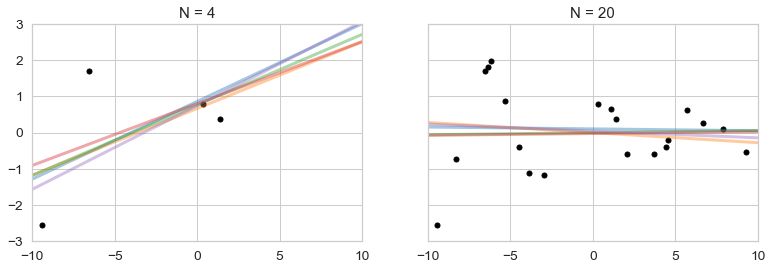

In [75]:
ncols = 2
_, axgrid = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*W+1, H), sharey=True, sharex=True)

for (panel_id, N) in [ (0, 4), (1, 20)]:
    axgrid[panel_id].plot(
        x_NF[:N,0], y_N[:N], 'k.', markersize=10)
    S_N = len(nn_samples_at_N[N])
    for ss in range(S_N):
        nn_params = nn_samples_at_N[N][ss]
        axgrid[panel_id].plot(
            x_grid_G1[:,0],
            predict_f_given_x_via_NN(x_grid_G1, nn_params),
            '-', linewidth=3, alpha=0.4)
    axgrid[panel_id].set_title("N = %d" % N)
plt.xlim([-10, 10]);
plt.ylim([-3, 3]);

In [76]:
arch = [64]

nn_samples_at_N = {}
S = 5

nn_samples_at_N[4] = draw_posterior_samples_via_rejection(
    arch, N=4, x_NF=x_NF, y_N=y_N, n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.003)


Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss   13.754086
iter  200/1000 after   0.2 sec : loss   13.717234
iter  400/1000 after   0.2 sec : loss   13.717233
iter  600/1000 after   0.2 sec : loss   13.717234
iter  800/1000 after   0.3 sec : loss   13.717234
iter 1000/1000 after   0.3 sec : loss   13.717234
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
..... accepted 4/ 10000 samples so far, will try 100000 total
DONE. Accepted 5/10671 samples from the prior


In [ ]:
nn_samples_at_N[8] = draw_posterior_samples_via_rejection(
    arch, N=8, x_NF=x_NF, y_N=y_N, n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.003)

Starting phase 1: Grad ascent to find a max-lik estimate of weights.
iter    0/1000 after   0.1 sec : loss    7.917123
iter  200/1000 after   0.2 sec : loss    7.825355
iter  400/1000 after   0.2 sec : loss    7.825356
iter  600/1000 after   0.2 sec : loss    7.825356
iter  800/1000 after   0.2 sec : loss    7.825356
iter 1000/1000 after   0.2 sec : loss    7.825356
DONE with phase 1. Maximum-likelihood estimate of weights found.
Starting phase 2: rejection sampling, seeking 5 samples from posterior
..... accepted 0/ 10000 samples so far, will try 100000 total
..... accepted 0/ 20000 samples so far, will try 100000 total
..... accepted 0/ 30000 samples so far, will try 100000 total
..... accepted 0/ 40000 samples so far, will try 100000 total
..... accepted 0/ 50000 samples so far, will try 100000 total


In [ ]:
nn_samples_at_N[20] = draw_posterior_samples_via_rejection(
    arch, N=20, x_NF=x_NF, y_N=y_N, n_samples=S,
    prior_params=prior_params,
    lik_params=lik_params,
    maxlik_step_size=0.003)


In [ ]:

ncols = 2
_, axgrid = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*W+1, H), sharey=True, sharex=True)

for (panel_id, N) in [ (0, 4), (1, 20)]:
    axgrid[panel_id].plot(
        x_NF[:N,0], y_N[:N], 'k.', markersize=10)
    S_N = len(nn_samples_at_N[N])
    for ss in range(S_N):
        nn_params = nn_samples_at_N[N][ss]
        axgrid[panel_id].plot(
            x_grid_G1[:,0],
            predict_f_given_x_via_NN(x_grid_G1, nn_params),
            linestyle='-',
            linewidth=3, alpha=0.4)
    axgrid[panel_id].set_title("N = %d" % N)
plt.xlim([-15, 15]);
plt.ylim([-15, 15]);

# Part 5: Posterior predictive


Recall that we want to predict via the posterior predictive density, averaging away all our uncertainty over weights and biases

\begin{align}
    p( y_* | \mathbf{y}_{1:N} ) 
        &= \int p( y_*, \mathbf{w}, \mathbf{b} | \mathbf{y}_{1:N} ) \,d\mathbf{w} \,db
        \\
        &= \int 
        \color{blue}{p( y_* | \mathbf{w}, \mathbf{b} )}
        \color{red}{p( \mathbf{w}, \mathbf{b} | \mathbf{y}_{1:N} )} \,d\mathbf{w} \,db
\end{align}

In practice, we don't have the posterior (red) in closed form for our NN model


If we can draw $S$ samples of $\mathbf{w}$ from the posterior, we can estimate the posterior predictive p.d.f. at a specific given $y_*$ via a Monte-Carlo estimate:

\begin{align}
    p( y_* | \mathbf{y}_{1:N} ) \approx \frac{1}{S} \sum_{s=1}^S \color{blue}{p( y_* | w^{(s)} )}, \qquad w^{(s)} \sim \color{red}{p( \mathbf{w} | \mathbf{y}_{1:N} )}
\end{align}

Alternatively, if we want to draw $S$ samples of $y_*$ from the posterior predictive $p( y_* | \mathbf{y}_{1:N})$, we can draw samples from the joint: first sample $w^{(s)}$ from posterior, then sample $y_*$ from its likelihood given $w^{(s)}$:

\begin{align}
    y_*^{(s)} \sim \color{blue}{p( y_* | w^{(s)} )}, \qquad w^{(s)} \sim \color{red}{p( \mathbf{w} | \mathbf{y}_{1:N} )}
\end{align}

We can keep the samples $\{ y_*^{(s)} \}_{s=1}^S$ as samples from $p( y_* | \mathbf{y}_{1:N} )$. We could compute empirical statistics of this $S$-sized set (e.g. mean, 5th percentile, 95th percentile) to summarize the distribution.